<a href="https://colab.research.google.com/github/Eugeneantientropy/ML100Days/blob/main/HW_Day_85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Work
試改變 monitor "Validation Accuracy" 並比較結果
調整 earlystop 的等待次數至 10, 25 並比較結果

In [ ]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [ ]:
train, test = keras.datasets.cifar10.load_data()

In [ ]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

In [ ]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [ ]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [ ]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [ ]:
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation loss

參數說明：
patience: 經過多少epochs後仍然沒有改善模型效能時停止訓練。
verbose: 運作狀況

使用說明：先定義出 Early stopping 的規則，再放入模型訓練中。

"""
from keras.callbacks import EarlyStopping

earlystop_25 = EarlyStopping(monitor="val_accuracy",
                             patience=1,
                       ) # Add mode='max' to tell the callback to maximize validation accuracy


In [ ]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[earlystop_25]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer1 (Dense)                │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer2 (Dense)                │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer3 (Dense)                │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_48']
Received: inputs=Tensor(shape=(None, 3072))
  warnings.warn(msg)


49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - accuracy: 0.2091 - loss: 2.4807 - val_accuracy: 0.2279 - val_loss: 2.0929
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 206ms/step - accuracy: 0.3822 - loss: 1.7788 - val_accuracy: 0.3194 - val_loss: 1.9523
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.4286 - loss: 1.6326 - val_accuracy: 0.3614 - val_loss: 1.8229
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.4588 - loss: 1.5513 - val_accuracy: 0.3999 - val_loss: 1.7114
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.4796 - loss: 1.4907 - val_accuracy: 0.4288 - val_loss: 1.6303
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 191ms/step - accuracy: 0.4990 - loss: 1.4413 - val_accuracy: 0.4423 - val_loss: 1.5877
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 11s 205ms/step - accuracy: 0.5128 - loss: 1.4005 - val_accuracy: 0.4568 - val_loss: 1.5431
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 0.5226 - loss: 1.3716 - val_accuracy: 0.4608 

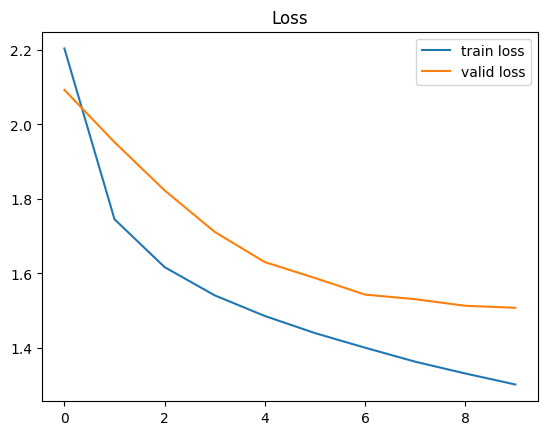

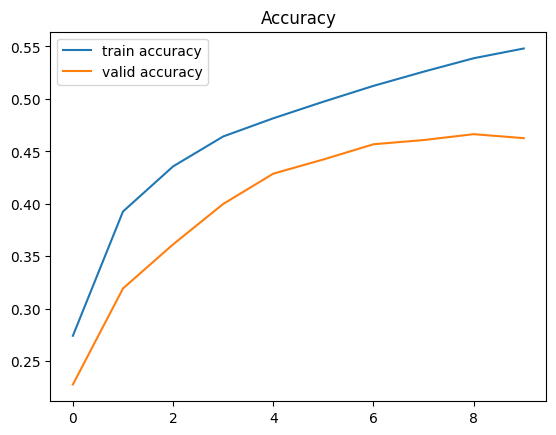

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

In [ ]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

In [ ]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [ ]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units,
                                   activation="relu",
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)

    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [ ]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [ ]:
from keras.callbacks import EarlyStopping

earlystop_25 = EarlyStopping(monitor="val_accuracy",
                             patience=1,
                       )

In [ ]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train,
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[earlystop_25]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer1 (Dense)                │ (None, 512)                 │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer2 (Dense)                │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hidden_layer3 (Dense)                │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,742,474 (6.65 MB)

 Trainable params: 1,740,682 (6.64 MB)

 Non-trainable params: 1,792 (7.00 KB)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_56']
Received: inputs=Tensor(shape=(None, 3072))
  warnings.warn(msg)


49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 208ms/step - accuracy: 0.1989 - loss: 2.5058 - val_accuracy: 0.2206 - val_loss: 2.1318
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.3761 - loss: 1.7909 - val_accuracy: 0.2805 - val_loss: 1.9773
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 181ms/step - accuracy: 0.4254 - loss: 1.6454 - val_accuracy: 0.3662 - val_loss: 1.8251
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.4539 - loss: 1.5568 - val_accuracy: 0.4128 - val_loss: 1.7197
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.4765 - loss: 1.4926 - val_accuracy: 0.4292 - val_loss: 1.6386
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.4926 - loss: 1.4577 - val_accuracy: 0.4456 - val_loss: 1.5886
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 180ms/step - accuracy: 0.5060 - loss: 1.4108 - val_accuracy: 0.4539 - val_loss: 1.5471
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 0.5218 - loss: 1.3753 - val_accuracy: 0.4661 -

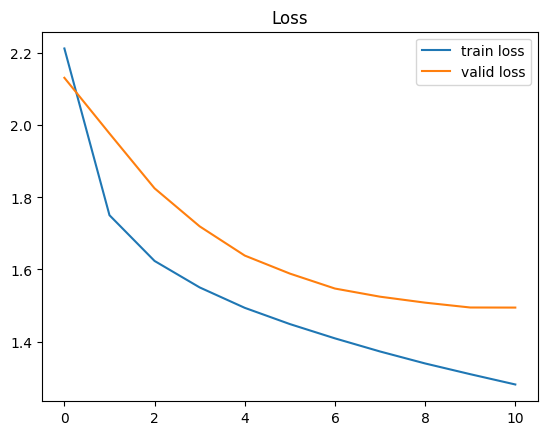

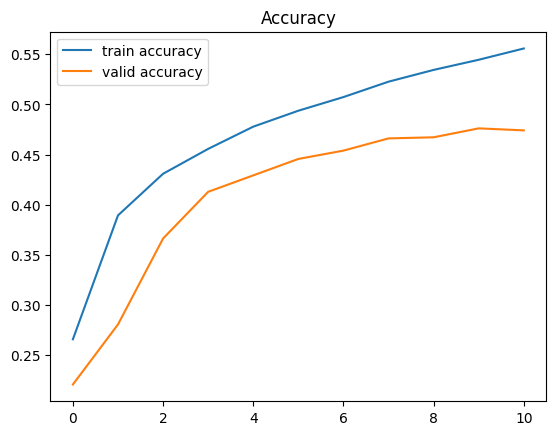

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()